In [1]:
cd /home/adrian/code/sideprojects/

/home/adrian/code/sideprojects


In [88]:
import sys
sys.path.append('/home/adrian/code/sideprojects/')

In [2]:
# import ladder_nets
# reload(ladder_nets)
from ladder_nets import build_model, build_cost

Using gpu device 2: Tesla K80 (CNMeM is disabled, cuDNN 4007)


In [3]:
num_encoder = [500, 10]
num_decoder = [500, 784]

[train_output_l, eval_output_l], dirty_net, clean_net = build_model(num_encoder, num_decoder, 0.3, 0.3, 
                                                                    batch_size=50, inp_size=784,
                                                                    combinator_type='milaUDEM')

In [4]:
map(lambda x: [x.name, x.output_shape], dirty_net.values())

[['input', (50, 784)],
 ['input_corr', (50, 784)],
 ['dirty_enc_dense_0', (50, 500)],
 ['dirty_enc_batchn_0_norm', (50, 500)],
 ['dirty_enc_noise_0_', (50, 500)],
 ['dirty_enc_batchn_0_learn', (50, 500)],
 ['dirty_enc_activation_0', (50, 500)],
 ['dirty_enc_dense_1', (50, 10)],
 ['dirty_enc_batchn_1_norm', (50, 10)],
 ['dirty_enc_noise_1_', (50, 10)],
 ['dirty_enc_batchn_1_learn', (50, 10)],
 ['dirty_enc_softmax', (50, 10)],
 ['dec_batchn_softmax', (50, 10)],
 ['dec_combinator_0', (50, 10)],
 ['dec_batchn_0', (50, 10)],
 ['dec_dense_1', (50, 500)],
 ['dec_batchn_dense_1', (50, 500)],
 ['dec_combinator_1', (50, 500)],
 ['dec_batchn_1', (50, 500)],
 ['dec_dense_2', (50, 784)],
 ['dec_combinator_2', (50, 784)]]

In [5]:
map(lambda x: [x.name, x.output_shape], clean_net.values())

[['input', (50, 784)],
 ['clean_enc_dense_0', (50, 500)],
 ['clean_enc_batchn_0_norm', (50, 500)],
 ['clean_enc_batchn_0_learn', (50, 500)],
 ['clean_enc_activation_0', (50, 500)],
 ['clean_enc_dense_1', (50, 10)],
 ['clean_enc_batchn_1_norm', (50, 10)],
 ['clean_enc_batchn_1_learn', (50, 10)],
 ['clean_enc_softmax', (50, 10)]]

In [6]:
import theano.tensor as T
import lasagne
import theano

In [7]:
# set up input/output variables
X = T.fmatrix('X')
y = T.imatrix('y')

# training output
output_train = lasagne.layers.get_output(train_output_l, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval = lasagne.layers.get_output(eval_output_l, X, deterministic=True)

# set up (possibly amortizable) lr, cost and updates
sh_lr = theano.shared(lasagne.utils.floatX(0.0005))

cost, rec_costs = build_cost(X, y, num_decoder, dirty_net, clean_net, output_train, [0.1]*3)

net_params = lasagne.layers.get_all_params(train_output_l, trainable=True)
updates = lasagne.updates.adam(cost, net_params, learning_rate=sh_lr)

# # get training and evaluation functions
train = theano.function([X, y], [cost + T.sum(rec_costs)] + rec_costs, updates=updates)
eval = theano.function([X], [output_eval])

In [ ]:
network_dump = {'output_layer': output_layer,
                'net': net,
                'x': X,
                'y': y,
                'output_eval': output_eval
                }

In [8]:
from fuel.datasets import MNIST
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme
from fuel.transformers import Flatten, OneHotEncoding, Duplicate, Mapping, \
    FilterSources, Merge

mnist = MNIST(which_sets=('train',), # sources='features',
              subset=slice(0, 50000), load_in_memory=True)
mnist_val = MNIST(which_sets=('train',), # sources='features',
                  subset=slice(50000, 60000), load_in_memory=True)
mnist_test = MNIST(which_sets=('test',), # sources='features',
                   load_in_memory=True)

batch_size = 100

data_stream = DataStream(mnist,
                         iteration_scheme=ShuffledScheme(mnist.num_examples,
                                                         batch_size=batch_size))

data_stream_val = DataStream(mnist_val,
                             iteration_scheme=ShuffledScheme(mnist_val.num_examples,
                                                             batch_size=batch_size))

data_stream_test = DataStream(mnist_test,
                              iteration_scheme=ShuffledScheme(mnist_test.num_examples,
                                                              batch_size=batch_size))

data_stream = Flatten(data_stream, which_sources=('features',))
data_stream_val = Flatten(data_stream_val, which_sources=('features',))
data_stream_test = Flatten(data_stream_test, which_sources=('features',))

num_classes = 10

data_stream = OneHotEncoding(data_stream=data_stream,
                             which_sources=('targets',),
                             num_classes=num_classes)

data_stream_val = OneHotEncoding(data_stream=data_stream_val,
                                 which_sources=('targets',),
                                 num_classes=num_classes)

data_stream_test = OneHotEncoding(data_stream=data_stream_test,
                                  which_sources=('targets',),
                                  num_classes=num_classes)

In [9]:
batch = next(data_stream.get_epoch_iterator())

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

[array(0.7222740358114242), array(0.008365500718355179, dtype=float32), array(0.013544824905693531, dtype=float32), array(0.05210600048303604, dtype=float32)]


(array([ 114.,   74.,   19.,   29.,   11.,   16.,   12.,   42.,   67.,  116.]),
 array([ 0.99610198,  0.99688592,  0.99766986,  0.99845381,  0.99923775,
         1.0000217 ,  1.00080564,  1.00158958,  1.00237353,  1.00315747,
         1.00394142]),
 <a list of 10 Patch objects>)

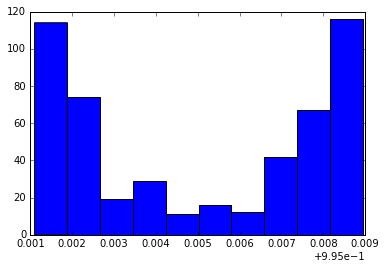

In [18]:
print train(*batch)
plt.hist(dirty_net['enc_batchn_0_learn'].gamma.get_value(borrow=True).ravel())

In [69]:
train_mean = theano.function([X, y], [cost, dirty_net['enc_batchn_0_norm'].mean, dirty_net['enc_batchn_0_norm'].inv_std,
                                      dirty_net['enc_batchn_0_learn'].mean, dirty_net['enc_batchn_0_learn'].inv_std],
                             updates=updates)

In [71]:
import numpy as np

0.485343794748


(array([   0.,    0.,    0.,    0.,    0.,  500.,    0.,    0.,    0.,    0.]),
 array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5]),
 <a list of 10 Patch objects>)

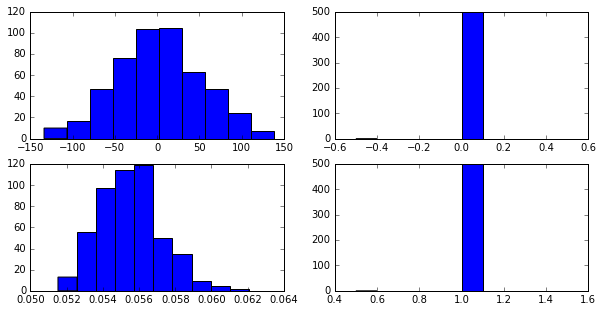

In [75]:
# batchnorm working!
cost_val, mean_norm, inv_std_norm, mean_learn, inv_std_learn = train_mean(*batch)
print cost_val
fig, ax = plt.subplots(2,2, figsize=[10,5])
ax[0,0].hist(np.asarray(mean_norm).ravel())
ax[0,1].hist(mean_learn.ravel(1))
ax[1,0].hist(np.asarray(inv_std_norm).ravel())
ax[1,1].hist(inv_std_learn.ravel(1))

In [20]:
map(lambda x: [x.name, x.output_shape], dirty_net.values())

[['input', (50, 784)],
 ['input_corr', (50, 784)],
 ['dirty_enc_dense_0', (50, 500)],
 ['dirty_enc_batchn_0_norm', (50, 500)],
 ['dirty_enc_noise_0_', (50, 500)],
 ['dirty_enc_batchn_0_learn', (50, 500)],
 ['dirty_enc_activation_0', (50, 500)],
 ['dirty_enc_dense_1', (50, 10)],
 ['dirty_enc_batchn_1_norm', (50, 10)],
 ['dirty_enc_noise_1_', (50, 10)],
 ['dirty_enc_batchn_1_learn', (50, 10)],
 ['dirty_enc_softmax', (50, 10)],
 ['dec_batchn_softmax', (50, 10)],
 ['dec_combinator_0', (50, 10)],
 ['dec_batchn_0', (50, 10)],
 ['dec_dense_1', (50, 500)],
 ['dec_batchn_dense_1', (50, 500)],
 ['dec_combinator_1', (50, 500)],
 ['dec_batchn_1', (50, 500)],
 ['dec_dense_2', (50, 784)],
 ['dec_combinator_2', (50, 784)]]

In [21]:
map(lambda x: [x.name, x.output_shape], clean_net.values())

[['input', (50, 784)],
 ['clean_enc_dense_0', (50, 500)],
 ['clean_enc_batchn_0_norm', (50, 500)],
 ['clean_enc_batchn_0_learn', (50, 500)],
 ['clean_enc_activation_0', (50, 500)],
 ['clean_enc_dense_1', (50, 10)],
 ['clean_enc_batchn_1_norm', (50, 10)],
 ['clean_enc_batchn_1_learn', (50, 10)],
 ['clean_enc_softmax', (50, 10)]]

In [42]:
from lasagne.layers import get_all_layers

In [44]:
W = lasagne.init.GlorotUniform()
beta=lasagne.init.Constant(0)
gamma=lasagne.init.Constant(1)

shp = (500,)
zero_const = T.zeros(shp, np.float32)
one_const = T.ones(shp, np.float32)

In [45]:
l1b = InputLayer((64, 768))
l2b = batch_norm(batch_norm(DenseLayer(l1, num_units=500, nonlinearity=tanh), 
                            beta=None, gamma=None), alpha=1., 
                 beta=beta, gamma=gamma, mean=zero_const, inv_std=one_const)
[l.__class__.__name__ for l in get_all_layers(l2b)]

['InputLayer',
 'DenseLayer',
 'BatchNormLayer',
 'NonlinearityLayer',
 'BatchNormLayer',
 'NonlinearityLayer']

In [46]:
l1 = InputLayer((64, 768))
l2 = DenseLayer(l1, num_units=500, nonlinearity=linear)
lb1 = BatchNormLayer(l2, alpha=0.1, beta=None, gamma=None)
lb2 = BatchNormLayer(lb1, alpha=1., beta=beta, gamma=gamma, 
                     mean=zero_const, inv_std=one_const)
l3 = NonlinearityLayer(lb2, nonlinearity=tanh)
[l.__class__.__name__ for l in get_all_layers(l3)]

['InputLayer',
 'DenseLayer',
 'BatchNormLayer',
 'BatchNormLayer',
 'NonlinearityLayer']

References:  
http://arxiv.org/pdf/1411.7783.pdf  
http://arxiv.org/pdf/1507.02672v2.pdf  
http://arxiv.org/pdf/1511.06430.pdf